# Capítulo 6 - Tarefas Continuadas: Formulação Alternativa


Você pode rodar este notebook localmente ou no Colab. Para abrir diretamente no Colab, basta clicar no link abaixo.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pablo-sampaio/rl_facil/blob/main/cap06/cap06-main-2.ipynb)

## Configurações Iniciais

In [1]:
from IPython.display import clear_output
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install gym==0.23.1
    !pip install optuna

    # clone repository
    !git clone https://github.com/pablo-sampaio/rl_facil
    sys.path.append("/content/rl_facil")

    clear_output()
else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )

clear_output()

In [17]:
import gym
from gym import spaces
import numpy as np
import optuna

from util.experiments import repeated_exec, repeated_exec_greedy_Q
from util.plot import plot_result, plot_multiple_results
from util.envs import TwoChoiceEnv, AccessControlEnv
from util.wrappers import FromDiscreteTupleToDiscreteObs

## 1 - Tarefa Continuada (Infinita)

Uma **tarefa continuada** (*continuing task*) é uma tarefa representada por um MDP sem estado terminal (que pode ser chamado de *MDP continuado* ou *MDP de horizonte infinito*).

Existem várias críticas quanto à aplicação de algoritmos baseados em *retornos descontados* nestes ambientes, conforme o artigo "*Discounted Reinforcement Learning is Not an Optimization Problem*" (Naik et al., 2019).

O artigo propõe o MDP abaixo para ilustrar as dificuldades de métodos como o *Q-Learning* e o *SARSA* em tarefas desse tipo:

<p align="center">
   <img src="https://github.com/pablo-sampaio/rl_facil/raw/main/cap06/two-choice-mdp-naik2019.jpg" alt="The Two-choice MDP (Naik et al., 2019)" width="500">
</p?>

Este MDP está implementado como ambiente `gym` na classe `util.env.TwoChoiceEnv`.

## 2 - Q-Learning (parando por passos)

Abaixo, segue o código do **Q-learning**, com uma pequena alteração em relação à implementação dada antes:
- o critério de parada agora é a *quantidade de passos*
- não importa a quantidade de episódios envolvida.

Este será o critério de parada na maioria dos algoritmos que veremos no futuro.

*Atenção: alguns gráficos vão mostrar o eixo "x" como "episódios", mas entenda como "passos".*

In [3]:
# Esta é a política. Neste caso, escolhe uma ação com base nos valores
# da tabela Q, usando uma estratégia epsilon-greedy.
def epsilon_greedy(Q, state, num_actions, epsilon):
    if np.random.random() < epsilon:
        return np.random.randint(0, num_actions)
    else:
        return np.argmax(Q[state])

In [4]:
# Algoritmo Q-learning
def run_qlearning_step(env, total_steps, lr=0.1, gamma=0.95, epsilon=0.1):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # inicializa a tabela Q com zeros
    # usar o estado como índice das linhas e a ação como índice das colunas
    Q = np.zeros(shape = (env.observation_space.n, num_actions))

    # guarda a recompensa de cada passo
    rewards_per_step = []

    state = env.reset()
    reward = 0

    # loop principal
    for i in range(total_steps):

        # escolhe a próxima ação -- usa epsilon-greedy
        action = epsilon_greedy(Q, state, num_actions, epsilon)

        # realiza a ação, ou seja, dá um passo no ambiente
        next_state, reward, done, _ = env.step(action)

        if done:
            # para estados terminais
            V_next_state = 0
            next_state = env.reset()
        else:
            # para estados não-terminais -- valor máximo (melhor ação)
            V_next_state = np.max(Q[next_state])

        # atualiza a Q-table
        # delta = (estimativa usando a nova recompensa) - estimativa antiga
        delta = (reward + gamma * V_next_state) - Q[state,action]
        Q[state,action] = Q[state,action] + lr * delta

        rewards_per_step.append(reward)

        state = next_state

        # a cada 1000 passos, imprime informação sobre o progresso
        if (i+1) % 1000 == 0:
            avg_reward = np.mean(rewards_per_step[-100:])
            print(f"Step {i+1} Average Reward (last 100): {avg_reward:.3f}")

    return rewards_per_step, Q

In [ ]:
TOTAL_STEPS = 100
LR = 0.3
GAMMA = 0.70   # só vai dar a política ótima para valores a partir de 0.85
EPSILON = 0.1

rmax = TOTAL_STEPS//2
env = TwoChoiceEnv()

rewards, qtable = run_qlearning_step(env, TOTAL_STEPS, LR, GAMMA, EPSILON)
print("Acumulado final =", sum(rewards))

In [ ]:
# Mostra um gráfico de passos x retornos não descontados acumulados
plot_result(rewards, rmax, cumulative=True, window=1)

## 3 - Differential Q-Learning

Um algoritmo específico para tarefas continuadas.

Ele é baseado na **formulação de recompensa média** para as tarefas (e os MDPs). Nessa formulação:
- é usado um *retorno* baseado nas diferenças entre cada recompensas real $R_t$ e a recompensa média até o passo $t$
- não existe o fator de desconto $\gamma$ (gamma)
- mas há um novo parâmetro $\eta$ (êta) que controla a "taxa de aprendizagem" da recompensa média estimada

In [12]:
# Algoritmo Differential Q-learning
def run_differential_qlearning_step(env, total_steps, lr=0.1, eta=1.0, epsilon=0.1):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # inicializa a tabela Q com zeros
    # usar o estado como índice das linhas e a ação como índice das colunas
    Q = np.zeros(shape = (env.observation_space.n, num_actions))

    # guarda a recompensa de cada passo
    rewards_per_step = []

    state = env.reset()
    reward = 0
    mean_reward = 0.0

    # loop principal
    for i in range(total_steps):

        # escolhe a próxima ação -- usa epsilon-greedy
        action = epsilon_greedy(Q, state, num_actions, epsilon)

        # realiza a ação, ou seja, dá um passo no ambiente
        next_state, reward, done, _ = env.step(action)

        assert not done, "This algorithm is for continuing tasks!"

        # para estados não-terminais -- valor máximo (melhor ação)
        V_next_state = np.max(Q[next_state])

        # atualiza a Q-table
        # delta = (estimativa usando a nova recompensa) - estimativa antiga
        delta = (reward - mean_reward + V_next_state) - Q[state,action]
        Q[state,action] = Q[state,action] + lr * delta

        # atualiza a recompensa média
        mean_reward += eta * lr * delta

        rewards_per_step.append(reward)
        state = next_state

        # a cada 1000 passos, imprime informação sobre o progresso
        if (i+1) % 1000 == 0:
            avg_reward = np.mean(rewards_per_step[-100:])
            print(f"Step {i+1} Average Reward (last 100): {avg_reward:.3f}")

    return rewards_per_step, Q

In [ ]:
TOTAL_STEPS = 100
LR = 0.3
ETA = 1.0
EPSILON = 0.1

rmax = TOTAL_STEPS//2
env = TwoChoiceEnv()

rewards, qtable = run_differential_qlearning_step(env, TOTAL_STEPS, LR, ETA, EPSILON)
print("Acumulado final =", (rewards[-1]))

In [ ]:
# Mostra um gráfico de passos x retornos não descontados acumulados
plot_result(rewards, rmax, cumulative=True, window=1)

## 4 - Otimizando Parâmetros

Vamos usar a biblioteca *Optuna* para otimizar os (hiper-)parâmetros dos algoritmos de treinamento.

In [10]:
ENV = TwoChoiceEnv()
RUNS_PER_TRIAL = 10

### 4.1 - Q-Learning

Vamos rodar duas otimizações separadas para estes dois valores de `gamma`: `0.7` e `0.9`.

Espera-se que o segundo valor (`0.9`) permita o Q-Learning chegar a um resultado ótimo, mas o primeiro valor (`0.7`) não.

In [ ]:
def create_train_fn(fixed_gamma):
    def train(trial : optuna.Trial):
        # chama os métodos do "trial" (tentativa) para sugerir valores para os parâmetros
        lr = trial.suggest_uniform('lr', 0.1, 1.0)
        eps = trial.suggest_uniform('epsilon', 0.01, 0.2)

        print(f"\nTRIAL #{trial.number}: lr={lr}, eps={eps}")

        # roda o algoritmo várias vezes
        results = repeated_exec(RUNS_PER_TRIAL, "qlearn-optuna", run_qlearning_step, ENV, 100, lr=lr, epsilon=eps, gamma=fixed_gamma)

        # soma dos retornos não-descontado finais
        return np.sum(results[1][:,-1])
    return train

In [6]:
GAMMA = 0.70
study = optuna.create_study(direction='maximize',
                        storage='sqlite:///optuna_continuing.db',
                        study_name=f'qlearning-g{GAMMA}',
                        load_if_exists=True)

study.optimize(create_train_fn(GAMMA), n_trials=50)
clear_output()

print("MELHORES PARÂMETROS PARA GAMMA", GAMMA, ":")
print(study.best_params)
qlearn_params_g07 = study.best_params
qlearn_params_g07['gamma'] = GAMMA

MELHORES PARÂMETROS PARA GAMMA 0.7 :
{'epsilon': 0.08939384035161647, 'lr': 0.36705421712333774}


In [7]:
GAMMA = 0.90
study = optuna.create_study(direction='maximize',
                        storage='sqlite:///optuna_continuing.db',
                        study_name=f'qlearning-g{GAMMA}',
                        load_if_exists=True)

study.optimize(create_train_fn(GAMMA), n_trials=50)
clear_output()

print("MELHORES PARÂMETROS PARA GAMMA", GAMMA, ":")
print(study.best_params)
qlearn_params_g09 = study.best_params
qlearn_params_g09['gamma'] = GAMMA

MELHORES PARÂMETROS PARA GAMMA 0.9 :
{'epsilon': 0.16639676370826717, 'lr': 0.11386771616749726}


### 4.2 - Differential Q-Learning

In [13]:
def train_diff(trial : optuna.Trial):
    # chama os métodos do "trial" (tentativa) para sugerir valores para os parâmetros
    lr = trial.suggest_uniform('lr', 0.1, 1.0)
    eps = trial.suggest_uniform('epsilon', 0.01, 0.20)
    eta = trial.suggest_uniform('eta', 0.1, 2.0)

    print(f"\nTRIAL #{trial.number}: lr={lr}, eps={eps}, eta={eta}")

    # roda o algoritmo várias vezes
    results = repeated_exec(RUNS_PER_TRIAL, "diff-qlearn-optuna", run_differential_qlearning_step, ENV, 100, lr=lr, epsilon=eps, eta=eta)

    # soma dos retornos não-descontado finais
    return np.sum(results[1][:,-1])


In [14]:
study = optuna.create_study(direction='maximize',
                        storage='sqlite:///optuna_continuing.db',
                        study_name='diff-qlearning',
                        load_if_exists=True)

study.optimize(train_diff, n_trials=50)
clear_output()

print("MELHORES PARÂMETROS:")
print(study.best_params)
diff_qlearn_params = study.best_params

MELHORES PARÂMETROS:
{'epsilon': 0.19214783966218202, 'eta': 1.8741910896363185, 'lr': 0.8625876881576253}


## 5 - Experimentos

### 5.1 - Desempenho no Treinamento

Comparando os dois usando os parâmetros ótimos obtidos antes.

In [18]:
#environment = TwoChoiceEnv()
environment = FromDiscreteTupleToDiscreteObs( AccessControlEnv() )
NUM_STEPS = 200
RUNS = 200

results = []

results.append( repeated_exec(RUNS, f"Q-Learning (g=0.7)", run_qlearning_step, environment, NUM_STEPS, **qlearn_params_g07) )
clear_output()

results.append( repeated_exec(RUNS, f"Q-Learning (g=0.9)", run_qlearning_step, environment, NUM_STEPS, **qlearn_params_g09) )
clear_output()

results.append( repeated_exec(RUNS, f"Diff Q-Learning", run_differential_qlearning_step, environment, NUM_STEPS, **diff_qlearn_params) )
clear_output()

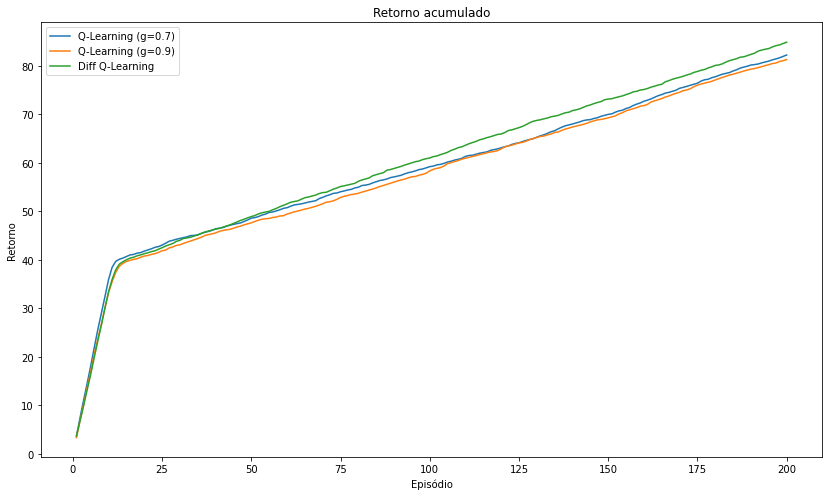

In [19]:
plot_multiple_results(results, cumulative='sum', window=1)

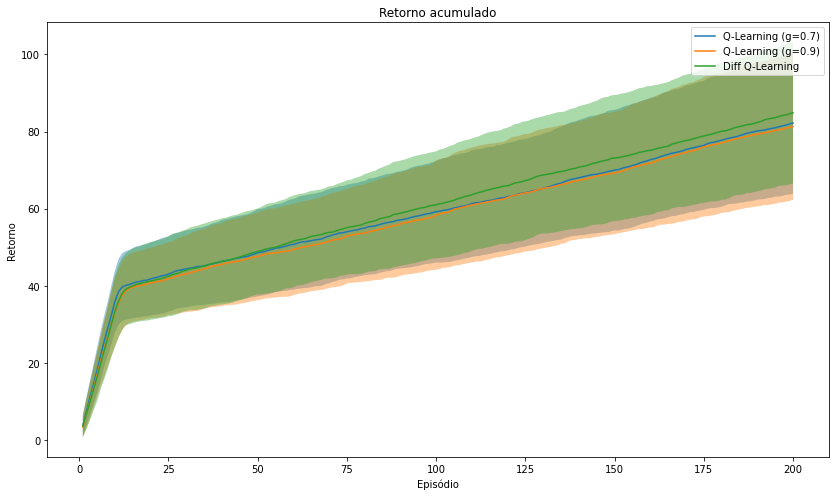

In [20]:
plot_multiple_results(results, cumulative='sum', window=1, plot_stddev=True)

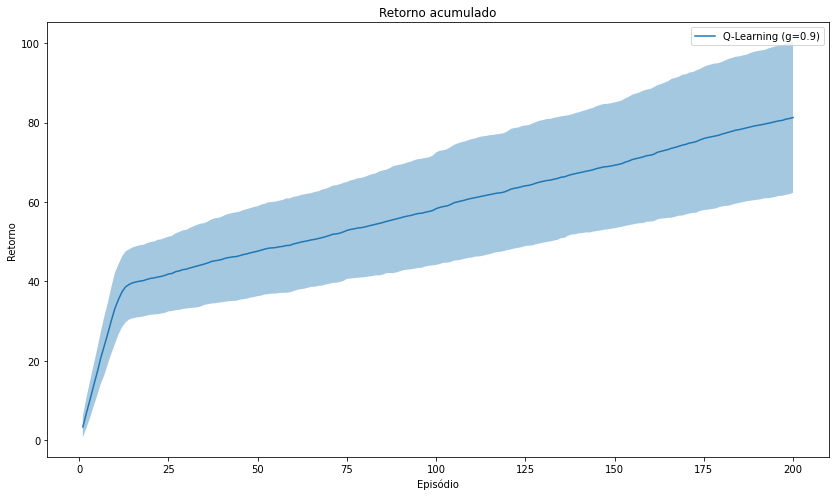

In [23]:
index = 1
plot_multiple_results(results[index:index+1], cumulative='sum', window=1, plot_stddev=True)

### 5.2 - Desempenho Pós-Treinamento

In [28]:
NUM_STEPS = 2000

Os experimentos abaixo são baseados em apenas 1 treinamento e, assim, que podem dar resultado abaixo do ótimo. Mas repetindo várias vezes será possível ver que o *Differential Q-Learning* e o *Q-Learning* com gammas altos (como `0.9`) atingem o ótimo, mas o *Q-Learning* com valor de gamma baixo (como `0.7`) não atinge.

In [29]:
_, qtable1 = run_qlearning_step(environment, NUM_STEPS, **qlearn_params_g07)
#_, qtable2 = run_qlearning_step(environment, NUM_STEPS, **qlearn_params_g09)
_, qtable3 = run_differential_qlearning_step(environment, NUM_STEPS, **diff_qlearn_params)

Step 1000 Average Reward (last 100): 0.080
Step 2000 Average Reward (last 100): 0.030
Step 1000 Average Reward (last 100): 0.210
Step 2000 Average Reward (last 100): 0.010


In [30]:
results = []

results.append( repeated_exec_greedy_Q(1, "QLearn(0.7)-Greedy", qtable1, environment, 1000) )
#results.append( repeated_exec_greedy_Q(1, "QLearn(0.9)-Greedy", qtable2, environment, 1000) )
results.append( repeated_exec_greedy_Q(1, "Diff-QLearn-Greedy", qtable3, environment, 1000) )

Executing <function repeated_exec_greedy_Q.<locals>.run_q_greedy at 0x000001D6959CBCA0>:


100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


  (1 executions of QLearn(0.7)-Greedy finished in 0.07 secs)
Executing <function repeated_exec_greedy_Q.<locals>.run_q_greedy at 0x000001D6959CBCA0>:


100%|██████████| 1/1 [00:00<00:00, 15.45it/s]

  (1 executions of Diff-QLearn-Greedy finished in 0.07 secs)


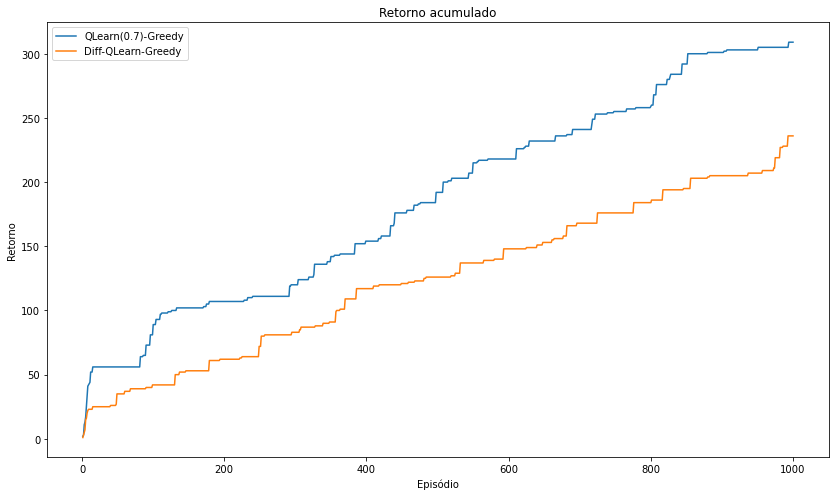

In [31]:
plot_multiple_results(results, cumulative='sum', window=1)

## 6 - Desafio

Já vimos que estes três algoritmos da formulação padrão (com retorno descontado) tem implementações parecidas: *Q-Learning*, o *SARSA* e o *Expected-SARSA* .

Na formulação com recompensa média, existe um algoritmo correspondente a cada um deles. O *Differential Q-Learning*, que vimos (na seção 2) é o correspondente do Q-Learning.

O desafio é este:
1. Implementar um *SARSA Diferencial*
1. Otimizar seus parâmetros
1. Rodar experimentos comparando-o com os algoritmos anteriores

Se quiser, faça o *SARSA Diferencial de n passos*. No livro tem uma implementação, mas usando "aproximação de função" para substituir a Q-Table.
